 # Deep learning meets missing data: Doing it MIWAE on MAR MNIST

 In this notebook, we'll learn a deep generative model on the MAR‐masked MNIST dataset and impute its missing pixels.

 # Installing and loading useful stuff

In [4]:
!pip3 install --user --upgrade scikit-learn

import torch
import torchvision
import torch.nn as nn
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td
from torch import optim
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer, SimpleImputer

from torchvision import transforms




[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


 # MAR mask definition

In [5]:
def create_mar_mask(data):
    masks = np.zeros((data.shape[0], data.shape[1]))
    for i, example in enumerate(data):
        h = (1. / (784. / 2.)) * np.sum(example[392:]) + 0.3
        pi = np.random.binomial(2, h)
        _mask = np.ones(example.shape[0])
        if pi == 0:
            _mask[196:392] = 0
        elif pi == 1:
            _mask[:392] = 0
        elif pi == 2:
            _mask[:196] = 0
        masks[i, :] = _mask
    return masks


 # Loading MNIST and applying MAR

In [6]:
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
mnist = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
data = mnist.data.float().view(-1, 784).numpy() / 255.0


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 8.21MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 292kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.75MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.87MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
np.random.seed(1234)
mask = create_mar_mask(data)
data_obs = data.copy()
data_obs[mask == 0] = np.nan


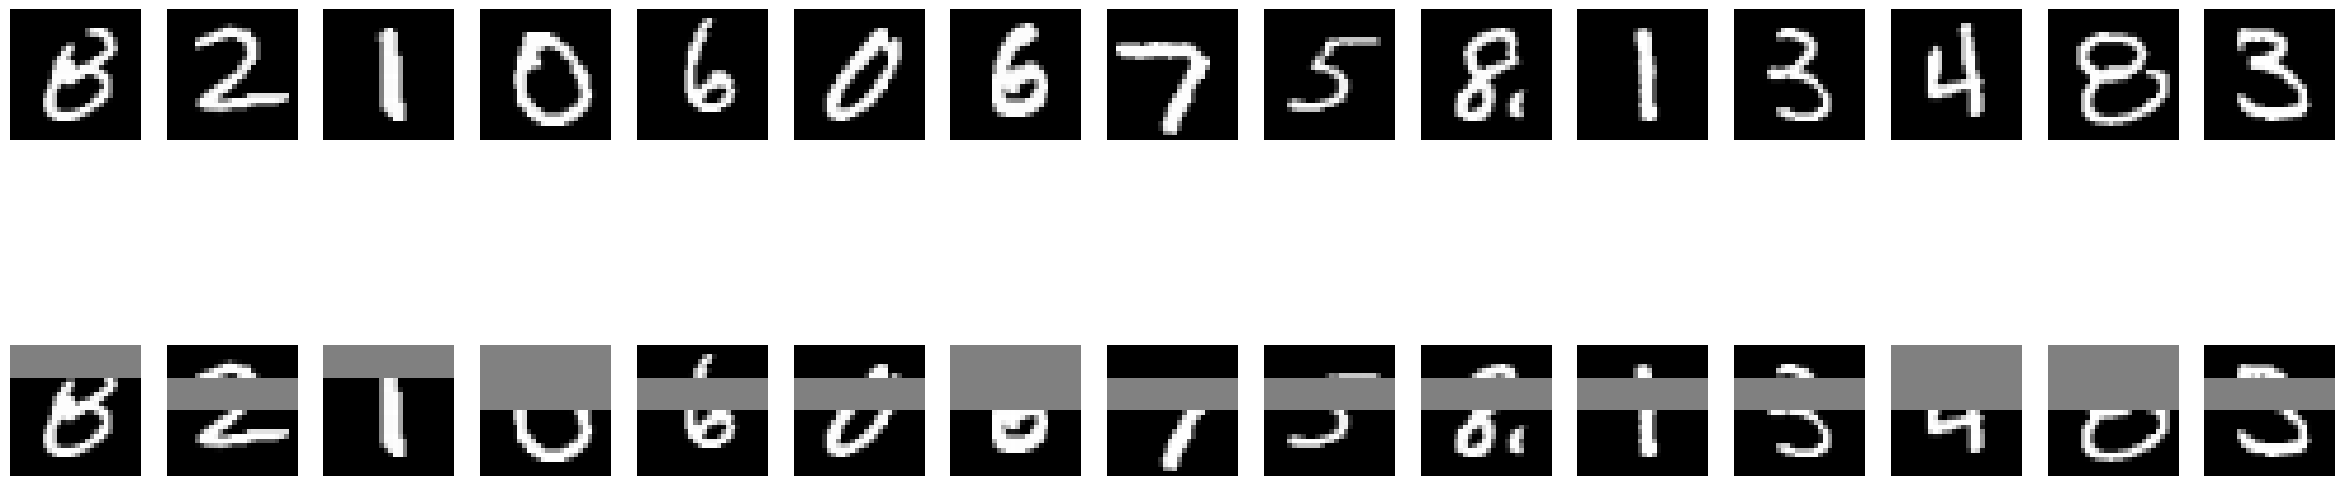

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# %%
n = data.shape[0]
indices = np.random.choice(n, 15, replace=False)
plt.figure(figsize=(30, 8))
for i, idx in enumerate(indices):
    orig = data[idx].reshape(28, 28)
    masked = data[idx].copy()
    masked[mask[idx] == 0] = 0.5  # Use grey (0.5) for masked pixels
    plt.subplot(2, 15, i + 1)
    plt.imshow(orig, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel('Original')
    plt.subplot(2, 15, i + 16)
    plt.imshow(masked.reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel('Masked')
plt.show()


 # Preprocessing

In [8]:
xfull = data_obs
n, p = xfull.shape
xobs_zero = np.nan_to_num(xfull, 0)
mask_bool = ~np.isnan(xfull)


 # Hyperparameters

In [ ]:
h = 128
d = 1
K = 20


 # Model building

In [ ]:
device = "cpu"
p_z = td.Independent(td.Normal(torch.zeros(d), torch.ones(d)), 1)

decoder = nn.Sequential(
    nn.Linear(d, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, 3 * p),
)

encoder = nn.Sequential(
    nn.Linear(p, h),
    nn.ReLU(),
    nn.Linear(h, h),
    nn.ReLU(),
    nn.Linear(h, 2 * d),
)

encoder.to(device)
decoder.to(device)


 # MIWAE loss

In [ ]:
def miwae_loss(iota_x, mask):
    batch = iota_x.shape[0]
    out = encoder(iota_x)
    q = td.Independent(td.Normal(out[..., :d], torch.nn.Softplus()(out[..., d:])), 1)
    z = q.rsample([K]).reshape([K * batch, d])
    dec = decoder(z)
    mu, scale, df = dec[:, :p], torch.nn.Softplus()(dec[:, p:2*p]) + 1e-3, torch.nn.Softplus()(dec[:, 2*p:]) + 3
    data_flat = iota_x.repeat(K, 1).reshape(-1, 1)
    mask_flat = mask.repeat(K, 1)
    log_px = td.StudentT(df=df.reshape(-1,1), loc=mu.reshape(-1,1), scale=scale.reshape(-1,1)).log_prob(data_flat)
    log_px = log_px.reshape(K * batch, p)
    log_px_obs = (log_px * mask_flat).reshape(K, batch, p).sum(-1)
    log_pz = p_z.log_prob(z.reshape(K, batch, d))
    log_q = q.log_prob(z.reshape(K, batch, d))
    bound = torch.logsumexp(log_px_obs + log_pz - log_q, 0) - torch.log(torch.tensor(K, dtype=torch.float))
    return -bound.mean()


In [ ]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)


 # Single imputation

In [ ]:
def miwae_impute(iota_x, mask, L, device):
    batch = iota_x.shape[0]
    out = encoder(iota_x)
    q = td.Independent(td.Normal(out[..., :d], torch.nn.Softplus()(out[..., d:])), 1)
    z = q.rsample([L]).reshape([L * batch, d])
    dec = decoder(z)
    mu, scale, df = dec[:, :p], torch.nn.Softplus()(dec[:, p:2*p]) + 1e-3, torch.nn.Softplus()(dec[:, 2*p:]) + 3
    log_px = td.StudentT(df=df.reshape(-1,1), loc=mu.reshape(-1,1), scale=scale.reshape(-1,1)).log_prob(
        iota_x.repeat(L,1).reshape(-1,1)
    ).reshape(L, batch, p)
    log_pz = p_z.log_prob(z.reshape(L, batch, d))
    log_q = q.log_prob(z.reshape(L, batch, d))
    w = torch.nn.functional.softmax(log_px.sum(-1) + log_pz - log_q, 0)
    x_samples = td.Independent(td.StudentT(df=df.reshape(-1,1), loc=mu.reshape(-1,1), scale=scale.reshape(-1,1)),1).sample().reshape(L, batch, p)
    return torch.einsum('lb,lbp->bp', w, x_samples)


 # Training

In [ ]:
xhat = xobs_zero.copy()
mask_t = mask_bool.astype(float)
bs = 64
epochs = 2000

for ep in range(1, epochs + 1):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        batch_id = idx[i:i+bs]
        b_x = torch.tensor(xhat[batch_id], dtype=torch.float).to(device)
        b_m = torch.tensor(mask_t[batch_id], dtype=torch.float).to(device)
        optimizer.zero_grad()
        loss = miwae_loss(b_x, b_m)
        loss.backward()
        optimizer.step()
    if ep % 100 == 0:
        with torch.no_grad():
            total_bound = -miwae_loss(torch.tensor(xhat, dtype=torch.float), torch.tensor(mask_t, dtype=torch.float))
        print(f'Epoch {ep} bound {total_bound.item()}')
        xhat_tensor = miwae_impute(torch.tensor(xhat, dtype=torch.float), torch.tensor(mask_t, dtype=torch.float), 10, device)
        xhat = xhat_tensor.cpu().numpy()
        print(f'Imputation MSE {np.mean((xhat - data)[~mask_bool]**2)}')


 # Comparisons with other methods

In [ ]:
imp = IterativeImputer(max_iter=20, estimator=ExtraTreesRegressor(n_estimators=100))
imp2 = IterativeImputer(max_iter=20, estimator=BayesianRidge())
imp.fit(data_obs)
imp2.fit(data_o_
